# Ejercicio 12: Multimodal Embeddings

# Nombre: Darlin Joel Anacicha  Curso: GR1CC

## Objetivo de la práctica

El objetivo de este ejercicio es observar cómo modelos multimodales como CLIP llevan texto e imágenes al mismo espacio vectorial, y verificar graficando embeddings en 2D.

### Pasos:

1. Obtener embeddings de imágenes y textos con CLIP.
2. Mostrar que ambos viven en el mismo espacio (misma dimensión y comparables).
3. Proyectar los vectores a 2D (PCA / t-SNE / UMAP) y graficarlos en un plano.
4. Verificar emparejamientos usando cosine similarity (búsqueda texto→imagen e imagen→texto).

In [36]:
from bs4 import BeautifulSoup
import os

In [37]:
ruta_archivo = "/kaggle/input/receta-dataset/Unstuffed Cabbage Roll Recipe.html"

In [38]:
# Usamos 'utf-8' para evitar problemas con tildes o caracteres especiales
with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
    contenido_html = archivo.read()

In [39]:
soup = BeautifulSoup(contenido_html, 'html.parser')

In [40]:
# Extracting the recipe title
title = soup.find("title")
title.string

'Unstuffed Cabbage Roll Recipe'

In [41]:
#score
#description
#prep time
#cooking time
#total time
#servings
#ingredients
#directtions
#nutritions facts
#Reviews

In [42]:
score=soup.find("div", {"id":"mm-recipes-review-bar__rating_1-0"})
score.string

'4.6'

In [43]:
description=soup.find("p", {"class":"article-subheading text-utility-300"})
description.string

"This is an easy casserole made with ground beef, cabbage, garlic, and tomatoes. My kids don't even like cabbage, but they love this dish! Serve with rice for a comforting weeknight dinner. Also, the longer it stands the better it tastes!"

In [44]:
prep_time=soup.find("div", {"class":"mm-recipes-details__value"})
prep_time.string

'15 mins'

Cargando modelo CLIP...

Procesando 2 recetas específicas...
--> Leyendo: Unstuffed Cabbage Roll Recipe.html
    Imagen encontrada: https://www.allrecipes.com/thmb/lma-Bky7zke2kV-NL07YtP-2D8M=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/235997-unstuffed-cabbage-roll-DDMFS-Beauty-2x1-f651631485be47a185d344a13f16a514.jpg...
    Embeddings generados con éxito.
--> Leyendo: 12 High-Protein Oatmeal Recipes To Prep for Breakfast All Week.html
    Imagen encontrada: https://www.allrecipes.com/thmb/wnBJ9sHG2Ab-hT4vOTSNsDK1i28=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/11699507-chia-seed-overnight-oats-2x1-07b46d13d2ec4344b5ff0e66423f53fe.jpg...
    Embeddings generados con éxito.


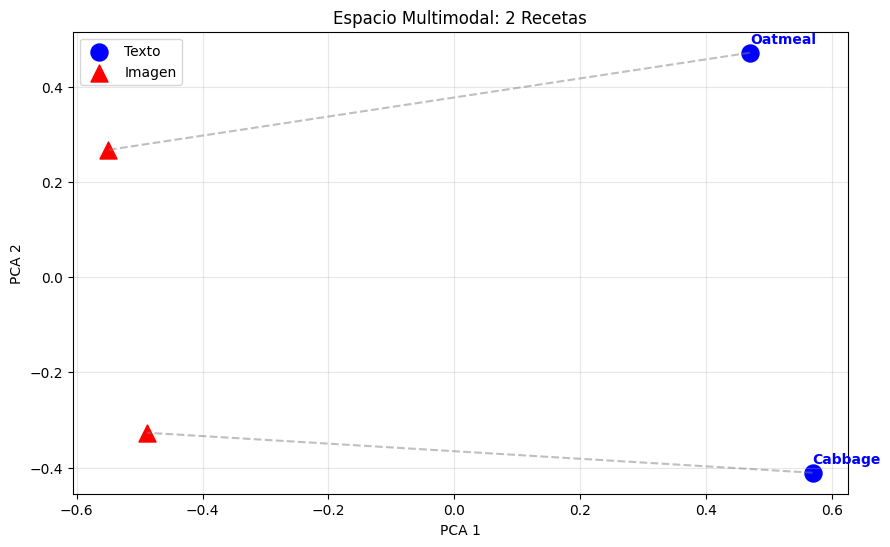


¡Ejercicio Completado!
Se graficaron 2 pares texto-imagen.


In [45]:
import os
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
from sklearn.decomposition import PCA
from transformers import CLIPProcessor, CLIPModel

# --- 1. CONFIGURACIÓN ---
# Definimos manualmente tus dos rutas exactas
rutas_archivos = [
    "/kaggle/input/receta-dataset/Unstuffed Cabbage Roll Recipe.html",
    "/kaggle/input/receta2-newdata/12 High-Protein Oatmeal Recipes To Prep for Breakfast All Week.html"
]

# Cargamos el modelo CLIP
print("Cargando modelo CLIP...")
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# --- 2. FUNCIONES ROBUSTAS ---

def parsearReceta(html_doc_path):
    """
    Extrae SOLO Título e Imagen (lo necesario para CLIP).
    Si faltan otros datos (score, time), no importa.
    """
    if not os.path.exists(html_doc_path):
        print(f"Advertencia: No se encuentra el archivo {html_doc_path}")
        return None

    with open(html_doc_path, 'r', encoding='utf-8') as archivo:
        soup = BeautifulSoup(archivo.read(), 'html.parser')
    
    # Intentamos sacar el título
    title_tag = soup.find("title")
    title_text = title_tag.get_text(strip=True) if title_tag else "Sin Título"
    
    # Intentamos sacar la URL de la imagen (Meta og:image es lo más fiable)
    img_meta = soup.find("meta", property="og:image")
    img_url = img_meta["content"] if img_meta else None
    
    return {
        "title": title_text,
        "image_url": img_url
    }

def cargar_imagen_web(url):
    """Descarga la imagen simulando ser un navegador"""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0",
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error descargando imagen {url}: {e}")
        return None

# --- 3. PROCESAMIENTO ---
titulos = []
text_embeds_list = []
image_embeds_list = []

print(f"\nProcesando {len(rutas_archivos)} recetas específicas...")

for ruta in rutas_archivos:
    print(f"--> Leyendo: {ruta.split('/')[-1]}")
    datos = parsearReceta(ruta)
    
    if datos and datos['image_url']:
        print(f"    Imagen encontrada: {datos['image_url'][:300]}...")
        img = cargar_imagen_web(datos['image_url'])
        
        if img:
            # CLIP: Texto vs Imagen
            inputs = processor(
                text=[datos['title']], 
                images=img, 
                return_tensors="pt", 
                padding=True
            )
            
            with torch.no_grad():
                outputs = model(**inputs)
            
            # Normalizar embeddings
            t_emb = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)
            i_emb = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
            
            titulos.append(datos['title'])
            text_embeds_list.append(t_emb.cpu().numpy())
            image_embeds_list.append(i_emb.cpu().numpy())
            print("    Embeddings generados con éxito.")
        else:
            print("    [X] Falló la descarga de la imagen.")
    else:
        print("    [X] No se encontró URL de imagen en el HTML.")

# --- 4. GRAFICAR (Si tenemos los 2 puntos) ---

if len(titulos) >= 2:
    # Convertir a matrices
    text_matrix = np.vstack(text_embeds_list)
    image_matrix = np.vstack(image_embeds_list)
    
    # Unir para PCA
    combined = np.concatenate([text_matrix, image_matrix], axis=0)
    
    # Reducción a 2D
    # Nota: Con 2 recetas (4 puntos en total), PCA funciona perfecto.
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined)
    
    # Separar
    n = len(titulos)
    t_2d = reduced[:n]
    i_2d = reduced[n:]
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    # Graficar puntos
    plt.scatter(t_2d[:, 0], t_2d[:, 1], c='blue', s=150, label='Texto', marker='o')
    plt.scatter(i_2d[:, 0], i_2d[:, 1], c='red', s=150, label='Imagen', marker='^')
    
    # Etiquetas y líneas
    for idx, titulo in enumerate(titulos):
        # Línea conectora
        plt.plot([t_2d[idx, 0], i_2d[idx, 0]], 
                 [t_2d[idx, 1], i_2d[idx, 1]], 
                 'gray', linestyle='--', alpha=0.5)
        
        # Poner nombre corto de la receta
        label = "Cabbage" if "Cabbage" in titulo else "Oatmeal"
        plt.text(t_2d[idx, 0], t_2d[idx, 1]+0.02, label, color='blue', fontweight='bold')
    
    plt.title("Espacio Multimodal: 2 Recetas")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\n¡Ejercicio Completado!")
    print(f"Se graficaron {len(titulos)} pares texto-imagen.")
    
else:
    print("\nERROR: No se lograron procesar ambas recetas. Revisa si tienes internet activado en Kaggle.")